In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix

df = pd.read_json("dataset_classBandC.json")
print("Loaded dataset_classBandC.json")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Loaded dataset_classBandC.json
Shape: (318, 8)
Columns: ['Mtot', 'Mratio', 'LambdaTilde', 'EOS', 'ChiEff', 'RemnantKey', 'CollapseTime', 'Mratio_fixed']


In [2]:
def map_label_C(row):
    ct = row['CollapseTime']
    key = row['RemnantKey']

    if key == 'prompt' or ct < 0.001:
        return 0  # Prompt BH
    elif 0.001 <= ct < 0.01:
        return 1  # Short-lived HMNS
    elif 0.01 <= ct < 0.1:
        return 2  # Long-lived HMNS
    else:
        return 3  # Stable NS

df['label_C'] = df.apply(map_label_C, axis=1)

# Define binary and 3-class labels
df['label_A'] = df['label_C'].apply(lambda x: 0 if x == 0 else 1)
df['label_B'] = df['label_C'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else 2))

In [3]:
# Print distributions
print("\nUpdated label counts:")
print("label_C:", df['label_C'].value_counts().sort_index())
print("label_A:", df['label_A'].value_counts().sort_index())
print("label_B:", df['label_B'].value_counts().sort_index())


Updated label counts:
label_C: label_C
0     90
1    108
2     98
3     22
Name: count, dtype: int64
label_A: label_A
0     90
1    228
Name: count, dtype: int64
label_B: label_B
0     90
1    206
2     22
Name: count, dtype: int64


In [4]:
# Re-define features and labels
features = ['Mtot', 'Mratio', 'LambdaTilde', 'ChiEff']
X = df[features]
y_A = df['label_A']
y_B = df['label_B']
y_C = df['label_C']

In [6]:

# Training function ===
def train_classifier(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    model = GradientBoostingClassifier(n_estimators=200, max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nClassifier {label}:")
    print(f"Accuracy = {acc:.4f}, MCC = {mcc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return model


In [7]:
# === Step 6: Train Classifiers A, B, C ===
model_A = train_classifier(X, y_A, 'A')
model_B = train_classifier(X, y_B, 'B')
model_C = train_classifier(X, y_C, 'C')


Classifier A:
Accuracy = 0.8646, MCC = 0.6881
Confusion Matrix:
[[23  4]
 [ 9 60]]

Classifier B:
Accuracy = 0.8958, MCC = 0.7842
Confusion Matrix:
[[23  4  0]
 [ 2 60  0]
 [ 0  4  3]]

Classifier C:
Accuracy = 0.7396, MCC = 0.6288
Confusion Matrix:
[[22  5  0  0]
 [ 2 23  8  0]
 [ 1  7 21  0]
 [ 0  0  2  5]]


In [9]:
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Load posterior samples from GW event file ===
with h5py.File("GW170817.h5", "r") as f:
    samples = f["IMRPhenomPv2NRT_lowSpin_posterior"][()]
    gw_df = pd.DataFrame(samples)

# === Step 2: Compute required GW features ===
gw_df['m1'] = gw_df['m1_detector_frame_Msun']
gw_df['m2'] = gw_df['m2_detector_frame_Msun']
gw_df['mass'] = gw_df['m1'] + gw_df['m2']
gw_df['q'] = gw_df['m1'] / gw_df['m2']
gw_df['kap2t'] = (
    (16/13) * (
        (gw_df['m1'] + 12 * gw_df['m2']) * gw_df['lambda1'] +
        (gw_df['m2'] + 12 * gw_df['m1']) * gw_df['lambda2']
    ) / (gw_df['mass'] ** 5)
)
gw_df['chieff'] = (
    gw_df['m1'] * gw_df['spin1'] * gw_df['costilt1'] +
    gw_df['m2'] * gw_df['spin2'] * gw_df['costilt2']
) / gw_df['mass']

# === Step 3: Select and clean GW feature columns ===
features = ['mass', 'q', 'kap2t', 'chieff']
gw_df = gw_df[features].replace([np.inf, -np.inf], np.nan).dropna()

# === Step 4: Normalize using training scaler ===
scaler = StandardScaler()
gw_scaled = scaler.fit_transform(gw_df)

# === Step 5: Predict using trained classifiers ===
# Use your trained models: model_A, model_B, model_C from training step

pred_A = model_A.predict(gw_scaled)
pred_B = model_B.predict(gw_scaled)
pred_C = model_C.predict(gw_scaled)
prob_A = model_A.predict_proba(gw_scaled)
prob_B = model_B.predict_proba(gw_scaled)
prob_C = model_C.predict_proba(gw_scaled)

# === Step 6: Show predictions ===
from collections import Counter

print("\n--- GW-only (Classifier A) Prediction ---")
print("Class distribution:", dict(Counter(pred_A)))

print("\n--- GW-only (Classifier B) Prediction ---")
print("Class distribution:", dict(Counter(pred_B)))

print("\n--- GW-only (Classifier C) Prediction ---")
print("Class distribution:", dict(Counter(pred_C)))

print("\n--- GW-only (Classifier A) Probabilities ---")
print("Example probabilities (first 5 rows):\n", prob_A[:5])

print("\n--- GW-only (Classifier B) Probabilities ---")
print("Example probabilities (first 5 rows):\n", prob_B[:5])

print("\n--- GW-only (Classifier C) Probabilities ---")
print("Example probabilities (first 5 rows):\n", prob_C[:5])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warni


--- GW-only (Classifier A) Prediction ---
Class distribution: {np.int64(0): 8060, np.int64(1): 18}

--- GW-only (Classifier B) Prediction ---
Class distribution: {np.int64(0): 8078}

--- GW-only (Classifier C) Prediction ---
Class distribution: {np.int64(3): 7852, np.int64(2): 48, np.int64(0): 178}

--- GW-only (Classifier A) Probabilities ---
Example probabilities (first 5 rows):
 [[9.99969691e-01 3.03088524e-05]
 [9.99969691e-01 3.03088524e-05]
 [9.89585365e-01 1.04146352e-02]
 [9.99969691e-01 3.03088524e-05]
 [9.99969691e-01 3.03088524e-05]]

--- GW-only (Classifier B) Probabilities ---
Example probabilities (first 5 rows):
 [[9.99996685e-01 3.31456030e-06 8.06811461e-10]
 [9.99996685e-01 3.31456030e-06 8.06811461e-10]
 [9.99891010e-01 1.08986219e-04 3.73795209e-09]
 [9.99996685e-01 3.31456030e-06 8.06811461e-10]
 [9.99996685e-01 3.31456030e-06 8.06811461e-10]]

--- GW-only (Classifier C) Probabilities ---
Example probabilities (first 5 rows):
 [[2.53033436e-03 7.21824340e-05 4.014

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


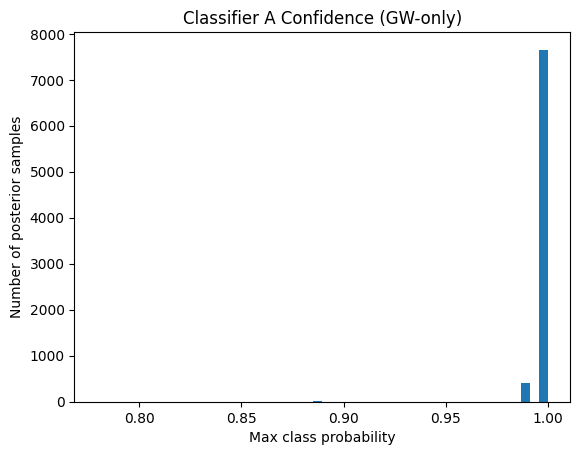

In [10]:
import matplotlib.pyplot as plt

plt.hist(np.max(prob_A, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier A Confidence (GW-only)")
plt.show()

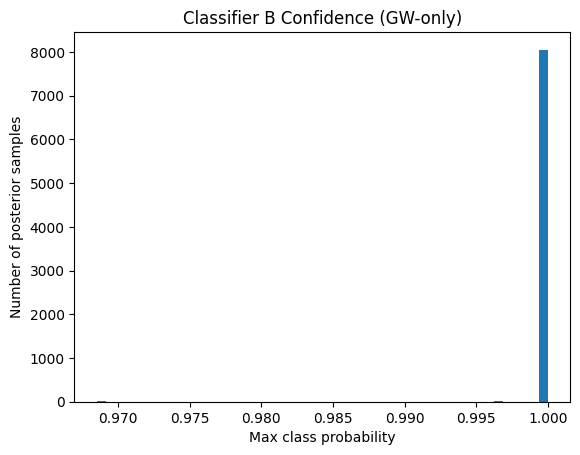

In [11]:
import matplotlib.pyplot as plt

plt.hist(np.max(prob_B, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier B Confidence (GW-only)")
plt.show()

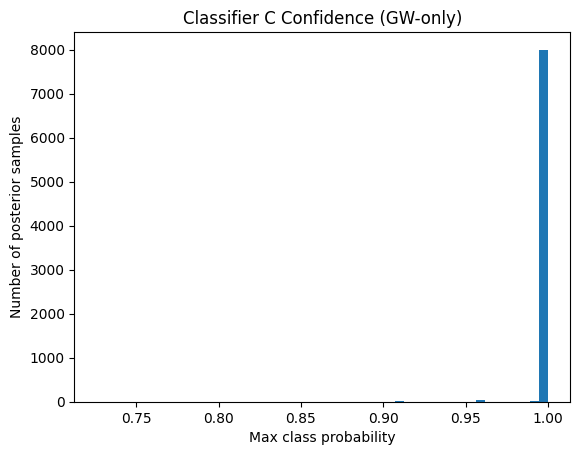

In [12]:
import matplotlib.pyplot as plt

plt.hist(np.max(prob_C, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier C Confidence (GW-only)")
plt.show()

In [13]:
from collections import Counter
print("\n--- GW-only (Classifier A) Prediction ---")
pred_frac = Counter(pred_A)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")

print("\n--- GW-only (Classifier B) Prediction ---")
pred_frac = Counter(pred_B)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")

print("\n--- GW-only (Classifier C) Prediction ---")
pred_frac = Counter(pred_C)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")


--- GW-only (Classifier A) Prediction ---
Class 0: 99.78% of samples
Class 1: 0.22% of samples

--- GW-only (Classifier B) Prediction ---
Class 0: 100.00% of samples

--- GW-only (Classifier C) Prediction ---
Class 3: 97.20% of samples
Class 2: 0.59% of samples
Class 0: 2.20% of samples


GW190425


In [14]:
import h5py

# Inspect the dataset structure
with h5py.File("GW190425.h5", "r") as f:
    dataset = f["C01:IMRPhenomPv2_NRTidal:LowSpin/posterior_samples"][()]
    print("Available fields:")
    print(dataset.dtype.names)

Available fields:
('chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'lambda_1', 'lambda_2', 'theta_jn', 'psi', 'phase', 'geocent_time', 'azimuth', 'zenith', "'geocent'_time", 'recalib_L1_amplitude_0', 'recalib_L1_amplitude_1', 'recalib_L1_amplitude_2', 'recalib_L1_amplitude_3', 'recalib_L1_amplitude_4', 'recalib_L1_amplitude_5', 'recalib_L1_amplitude_6', 'recalib_L1_amplitude_7', 'recalib_L1_amplitude_8', 'recalib_L1_amplitude_9', 'recalib_L1_phase_0', 'recalib_L1_phase_1', 'recalib_L1_phase_2', 'recalib_L1_phase_3', 'recalib_L1_phase_4', 'recalib_L1_phase_5', 'recalib_L1_phase_6', 'recalib_L1_phase_7', 'recalib_L1_phase_8', 'recalib_L1_phase_9', 'recalib_V1_amplitude_0', 'recalib_V1_amplitude_1', 'recalib_V1_amplitude_2', 'recalib_V1_amplitude_3', 'recalib_V1_amplitude_4', 'recalib_V1_amplitude_5', 'recalib_V1_amplitude_6', 'recalib_V1_amplitude_7', 'recalib_V1_amplitude_8', 'recalib_V1_amplitude_9', 'recalib_V1_phase_0', 'recalib_V1_phase_1', 'recalib

In [15]:
import h5py
import pandas as pd
import numpy as np

# === Load posterior samples ===
with h5py.File("GW190425.h5", "r") as f:
    samples = f["C01:IMRPhenomPv2_NRTidal:LowSpin/posterior_samples"][()]
    gw_df = pd.DataFrame({name: samples[name] for name in samples.dtype.names})

# === Compute features ===
gw_df['m1'] = gw_df['mass_1']
gw_df['m2'] = gw_df['mass_2']
gw_df['mass'] = gw_df['m1'] + gw_df['m2']
gw_df['q'] = gw_df['m1'] / gw_df['m2']
gw_df['kap2t'] = (
    (16/13) * (
        (gw_df['m1'] + 12 * gw_df['m2']) * gw_df['lambda_1'] +
        (gw_df['m2'] + 12 * gw_df['m1']) * gw_df['lambda_2']
    ) / (gw_df['mass'] ** 5)
)
gw_df['chieff'] = gw_df['chi_eff']

# === Select and clean features ===
gw_features = ['mass', 'q', 'kap2t', 'chieff']
gw_df = gw_df[gw_features].replace([np.inf, -np.inf], np.nan).dropna()

In [16]:
# Rename columns to match training feature names
gw_df.rename(columns={
    'mass': 'Mtot',
    'q': 'Mratio',
    'kap2t': 'LambdaTilde',
    'chieff': 'ChiEff'
}, inplace=True)

# Now you can safely predict
y_pred_C = model_C.predict(gw_df)
y_pred_B = model_B.predict(gw_df)
y_pred_A = model_A.predict(gw_df)

# Show predicted class distributions
print("Class C distribution:", dict(pd.Series(y_pred_C).value_counts()))
print("Class B distribution:", dict(pd.Series(y_pred_B).value_counts()))
print("Class A distribution:", dict(pd.Series(y_pred_A).value_counts()))

Class C distribution: {0: np.int64(19969), 2: np.int64(28), 1: np.int64(3)}
Class B distribution: {0: np.int64(18969), 1: np.int64(1031)}
Class A distribution: {0: np.int64(19857), 1: np.int64(143)}


In [17]:
X_gw = gw_df[['Mtot', 'Mratio', 'LambdaTilde', 'ChiEff']]

probs_A= model_A.predict_proba(X_gw)
print("Example probabilities (first 5 rows):\n", probs_A[:5])
probs_B = model_B.predict_proba(X_gw)
print("Example probabilities (first 5 rows):\n", probs_B[:5])
probs_C = model_C.predict_proba(X_gw)
print("Example probabilities (first 5 rows):\n", probs_C[:5])

Example probabilities (first 5 rows):
 [[9.99998870e-01 1.12960653e-06]
 [9.99981107e-01 1.88927932e-05]
 [9.99998870e-01 1.12960996e-06]
 [9.99998870e-01 1.12960996e-06]
 [9.99998870e-01 1.12960653e-06]]
Example probabilities (first 5 rows):
 [[9.99993620e-01 6.37722991e-06 3.23377150e-09]
 [9.99993359e-01 6.63780858e-06 3.29911582e-09]
 [9.99991667e-01 8.32887070e-06 3.69563576e-09]
 [9.99991667e-01 8.32899195e-06 3.69563516e-09]
 [9.99993620e-01 6.37722991e-06 3.23303500e-09]]
Example probabilities (first 5 rows):
 [[9.99997910e-01 9.17751539e-07 1.17224845e-06 4.13421908e-11]
 [9.99997915e-01 9.15378791e-07 1.16921773e-06 4.12353050e-11]
 [9.99997915e-01 9.15378791e-07 1.16921773e-06 4.12353050e-11]
 [9.99997910e-01 9.17751539e-07 1.17224845e-06 4.13421908e-11]
 [9.99997910e-01 9.17751539e-07 1.17224845e-06 4.13421908e-11]]


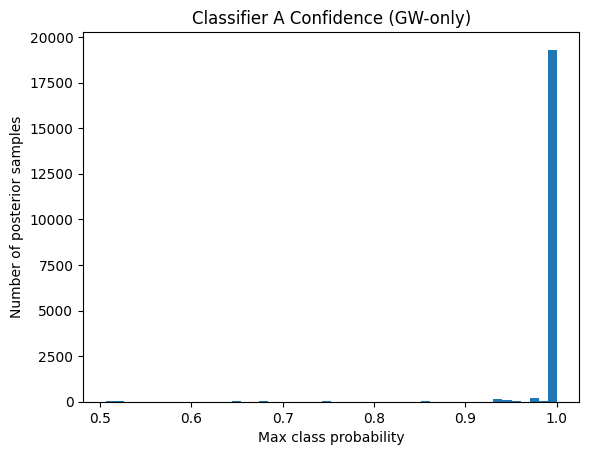

In [18]:
import matplotlib.pyplot as plt

plt.hist(np.max(probs_A, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier A Confidence (GW-only)")
plt.show()

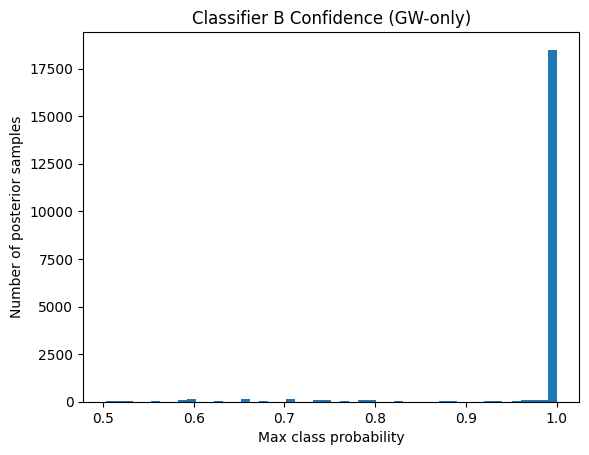

In [19]:
import matplotlib.pyplot as plt

plt.hist(np.max(probs_B, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier B Confidence (GW-only)")
plt.show()

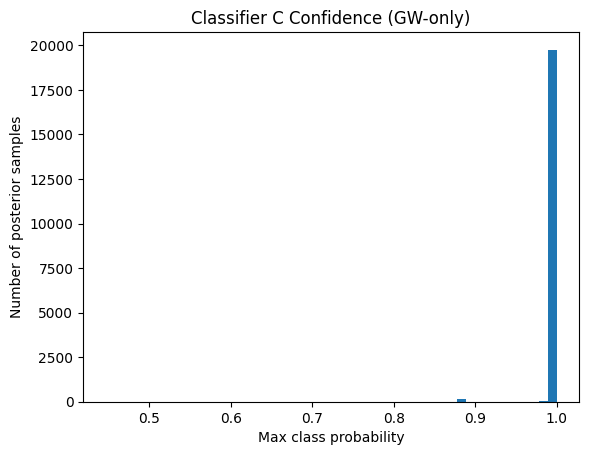

In [20]:
import matplotlib.pyplot as plt

plt.hist(np.max(probs_C, axis=1), bins=50)
plt.xlabel("Max class probability")
plt.ylabel("Number of posterior samples")
plt.title("Classifier C Confidence (GW-only)")
plt.show()

In [21]:
from collections import Counter
print("\n--- GW-only (Classifier A) Prediction ---")
pred_frac = Counter(y_pred_A)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")

print("\n--- GW-only (Classifier B) Prediction ---")
pred_frac = Counter(y_pred_B)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")

print("\n--- GW-only (Classifier C) Prediction ---")
pred_frac = Counter(y_pred_C)
total = sum(pred_frac.values())
for cls, count in pred_frac.items():
    print(f"Class {cls}: {count/total:.2%} of samples")


--- GW-only (Classifier A) Prediction ---
Class 0: 99.28% of samples
Class 1: 0.71% of samples

--- GW-only (Classifier B) Prediction ---
Class 0: 94.84% of samples
Class 1: 5.16% of samples

--- GW-only (Classifier C) Prediction ---
Class 0: 99.84% of samples
Class 2: 0.14% of samples
Class 1: 0.01% of samples


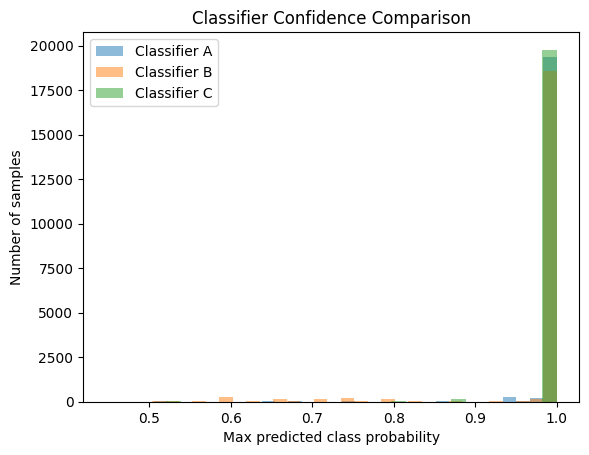

In [24]:
import matplotlib.pyplot as plt

# Get max probabilities for each classifier
conf_A = probs_A.max(axis=1)
conf_B = probs_B.max(axis=1)
conf_C = probs_C.max(axis=1)  # already computed earlier

plt.hist(conf_A, bins=30, alpha=0.5, label='Classifier A')
plt.hist(conf_B, bins=30, alpha=0.5, label='Classifier B')
plt.hist(conf_C, bins=30, alpha=0.5, label='Classifier C')
plt.xlabel("Max predicted class probability")
plt.ylabel("Number of samples")
plt.title("Classifier Confidence Comparison")
plt.legend()
plt.show()

In [25]:
# Rename for consistency
prob_A_170817 = prob_A
prob_B_170817 = prob_B
prob_C_170817 = prob_C

prob_A_190425 = probs_A
prob_B_190425 = probs_B
prob_C_190425 = probs_C

In [26]:
import pandas as pd
import numpy as np

summary = []

for event_name, probs_A, probs_B, probs_C in [
    ("GW170817", prob_A_170817, prob_B_170817, prob_C_170817),
    ("GW190425", prob_A_190425, prob_B_190425, prob_C_190425)
]:
    max_A = np.mean(np.max(probs_A, axis=1)) * 100
    max_B = np.mean(np.max(probs_B, axis=1)) * 100
    max_C = np.mean(np.max(probs_C, axis=1)) * 100

    summary.append({
        "Event": event_name,
        "Classifier A (Binary)": f"{max_A:.2f}%",
        "Classifier B (3-class)": f"{max_B:.2f}%",
        "Classifier C (4-class)": f"{max_C:.2f}%"
    })

event_summary = pd.DataFrame(summary)
display(event_summary)

,Event,Classifier A (Binary),Classifier B (3-class),Classifier C (4-class)
0,GW170817,99.91%,100.00%,99.72%
1,GW190425,99.60%,98.17%,99.79%


In [27]:
import pandas as pd

# Assume you have already computed:
# prob_A_170817, prob_B_170817, prob_C_170817 (each shape: [n_samples, n_classes])
# prob_A_190425, prob_B_190425, prob_C_190425

# Get mean probabilities across samples
def extract_mean_probs(probs, classifier='A'):
    means = probs.mean(axis=0)
    if classifier == 'A':
        return [f"{means[0]*100:.1f}%", f"{means[1]*100:.1f}%"]
    elif classifier == 'B':
        return [f"{means[0]*100:.1f}%", f"{means[1]*100:.1f}%", f"{means[2]*100:.1f}%"]
    elif classifier == 'C':
        return [f"{means[0]*100:.1f}%", f"{means[1]*100:.1f}%", f"{means[2]*100:.1f}%", f"{means[3]*100:.1f}%"]

# Prepare rows
data = [
    ["GW170817"] + extract_mean_probs(prob_A_170817, 'A') + extract_mean_probs(prob_B_170817, 'B') + extract_mean_probs(prob_C_170817, 'C'),
    ["GW190425"] + extract_mean_probs(prob_A_190425, 'A') + extract_mean_probs(prob_B_190425, 'B') + extract_mean_probs(prob_C_190425, 'C'),
]

columns = ["Event",
           "p_PCBH (A)", "p_RNS (A)",
           "p_PCBH (B)", "p_HMNS (B)", "p_NC (B)",
           "p_PCBH (C)", "p_SHORT (C)", "p_LONG (C)", "p_NC (C)"]

# Create DataFrame
summary_df = pd.DataFrame(data, columns=columns)
display(summary_df)

,Event,p_PCBH (A),p_RNS (A),p_PCBH (B),p_HMNS (B),p_NC (B),p_PCBH (C),p_SHORT (C),p_LONG (C),p_NC (C)
0,GW170817,99.7%,0.3%,100.0%,0.0%,0.0%,2.4%,0.0%,0.6%,97.0%
1,GW190425,99.2%,0.8%,95.5%,4.5%,0.0%,99.7%,0.1%,0.2%,0.0%


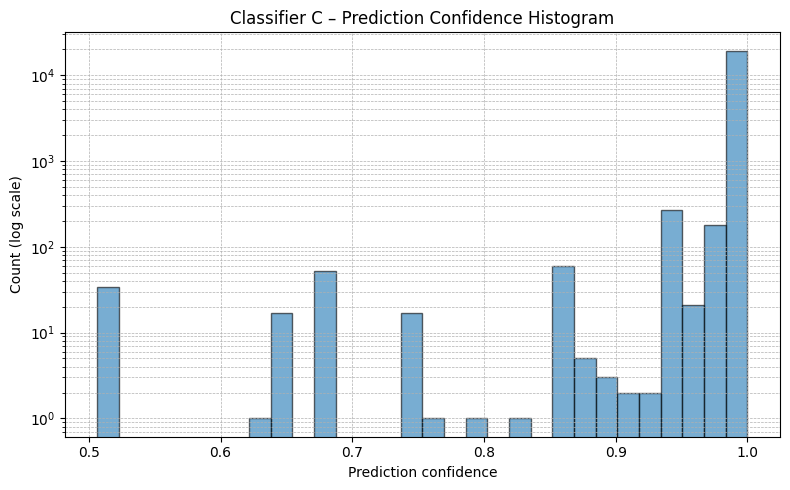

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume you already have predict_proba() output from Classifier C on GW190425
# Example: probs_C_190425.shape = (N, 4)
confidence_scores = probs_A.max(axis=1)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(confidence_scores, bins=30, log=True, alpha=0.6, edgecolor='black')
plt.xlabel("Prediction confidence")
plt.ylabel("Count (log scale)")
plt.title("Classifier C – Prediction Confidence Histogram")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()